In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def strDate_to_days(row, date_format = "%Y-%m-%d"):
    '''
        When there's no FLAG_DECES column in the df
    '''
    a = datetime.strptime(row['Date deces'], date_format)
    b = datetime.strptime(row['Date cr'], date_format)
    val = (a-b).days
    return val

def changeFormat(df: pd.DataFrame, flag_GR: bool):
    if(flag_GR):
        df = df[0].str.split(',', expand=True)
        df = df.iloc[1:,[0,2,3]]
        df.columns = ["Noigr", "Date deces", "Date cr"]

    df['Date cr'] = df['Date cr'].apply(lambda x: str(x) )
    df['Date cr'] = df['Date cr'].apply(lambda x: '-'.join([x[:4], x[4:6], x[6:]]))
    df['Date deces'] = df['Date deces'].apply(lambda x: str(x) )
    df['Date deces'] = df['Date deces'].apply(lambda x: '-'.join([x[:4], x[4:6], x[6:]]))
    df['survival_time'] = df.apply(strDate_to_days, axis=1)

    return df

In [3]:
# Read data
train_GR = pd.read_fwf('doc_GR\\Survival_train.csv', header=None)
train_GR = changeFormat(train_GR, True)
test_GR = pd.read_fwf('doc_GR\\Survival_test.csv', header=None)
test_GR = changeFormat(test_GR, True)

# Split into train/validation
validation_split = pd.read_csv("doc_GR\\validation_split.csv", dtype=bool)
train_GR = train_GR.reset_index().drop(columns=['index']) # Reset index
validation_GR = train_GR[validation_split["validation"]]
train_GR = train_GR.drop(validation_GR.index)

height = [np.mean(train_GR['survival_time']), 
            np.mean(validation_GR['survival_time']),
            np.mean(test_GR['survival_time'])]
bars = ('GR train', 'GR val', 'GR test')

In [4]:
for i in range(10):
    # Read dataframe
    df = pd.read_csv("doc_toTest\\test_rs"+str(i)+".csv")
    df = changeFormat(df, False)

    # Add survival time to list
    height.append(np.mean(df['survival_time']))
    bars += ("CLB_"+str(i), )
    

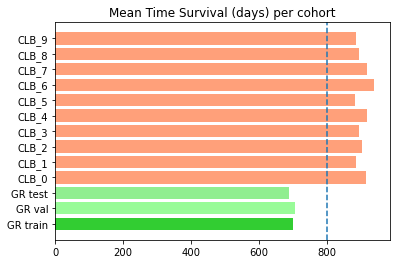

In [5]:
fig, ax = plt.subplots()
y_pos = np.arange(len(bars))
plt.barh(y_pos, height, 
    color=['limegreen', 'palegreen', 'lightgreen']+['lightsalmon']*10)
plt.yticks(y_pos, bars)

# Plot vertical line
plt.axvline(x=800, linestyle="--")
#plt.axvline(x=1800, linestyle="--")
trans = ax.get_xaxis_transform()
plt.text(800, .05, ' GR Mean \n Survival', transform=trans)
#plt.text(1800, .05, 'CLB', transform=trans)
plt.title('Mean Time Survival (days) per cohort')
plt.show()

Text(0.5, 1.0, 'Survival Curve : Survival Time at each consultation [Kaplan Meier]')

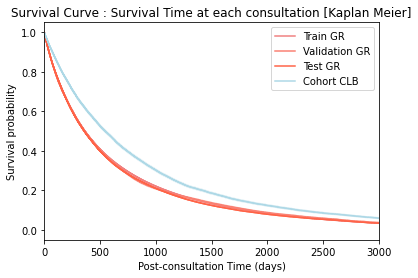

In [39]:
######################################################################
# Courbe de survie GR + CLB
fig, ax = plt.subplots()

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(train_GR['survival_time'], label="Train GR")
kmf.plot_survival_function(color="lightcoral")

kmf.fit(validation_GR['survival_time'], label="Validation GR")
kmf.plot_survival_function(color="salmon")

kmf.fit(test_GR['survival_time'], label="Test GR")
kmf.plot_survival_function(color="tomato")

kmf.fit(df_CLB['survival_time'], label="Cohort CLB")
kmf.plot_survival_function(color="lightblue")

ax.set_xlim([0, 3000])
#ax.set_ylim([ymin, ymax])
plt.xlabel('Post-consultation Time (days)')
plt.ylabel('Survival probability')

plt.title("Survival Curve : Survival Time at each consultation [Kaplan Meier]")

In [11]:
def label_to_time_survival(label, mean_time_survival):
    """
    Transforms labels in ]0,1[ into times of survival
    """
    return - mean_time_survival*np.log(
        np.clip(1-label, a_min=1e-5, a_max=1))

df_CLB = pd.read_csv("doc_Tested\\resu_pred0.csv")
df_CLB['survival_time'] = df_CLB['lab'].apply(lambda x : label_to_time_survival(x, 800))


,Unnamed: 0,pred,lab,survival_time
0,0,0.711800,0.582095,698.000055
1,1,0.375235,0.612291,758.000009


# Courbe de Survie

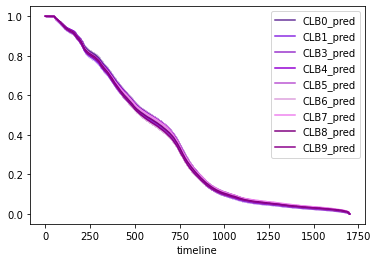

In [30]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter

# Function to transform label to survival time
def label_to_time_survival(label, mean_time_survival):
    """
    Transforms labels in ]0,1[ into times of survival
    """
    return - mean_time_survival*np.log(
        np.clip(1-label, a_min=1e-5, a_max=1))

# Color to plot differents CLB cohort
keys_color = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
values_color = ["rebeccapurple", "blueviolet", "indigo", "darkorchid", "darkviolet", 
                "mediumorchid", "plum", "violet", "purple", "darkmagenta"]
colors = {}
for (key, value) in zip(keys_color, values_color):
    colors[key] = value

# Initialize survival Model
kmf = KaplanMeierFitter()

# For each cohort, read data, transform label to survival and plot KM
for i in [0, 1, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Create survival time column
    df['survival_time_pred'] = df['pred'].apply(lambda x : label_to_time_survival(x, 800))
    df['survival_time'] = df['lab'].apply(lambda x : label_to_time_survival(x, 800))
    # Fit KM and plot
    # Prediction
    kmf.fit(df['survival_time_pred'], label="CLB"+str(i)+"_pred")
    kmf.plot_survival_function(color=colors[i])

# Courbe de survie avec TOUT

In [10]:
# Read data
train_GR = pd.read_fwf('doc_GR\\Survival_train.csv', header=None)
train_GR = changeFormat(train_GR, True)
test_GR = pd.read_fwf('doc_GR\\Survival_test.csv', header=None)
test_GR = changeFormat(test_GR, True)

# Split into train/validation
validation_split = pd.read_csv("doc_GR\\validation_split.csv", dtype=bool)
train_GR = train_GR.reset_index().drop(columns=['index']) # Reset index
validation_GR = train_GR[validation_split["validation"]]
train_GR = train_GR.drop(validation_GR.index)

Text(0.5, 1.0, 'Survival Curve : Survival Time at each consultation [Kaplan Meier]')

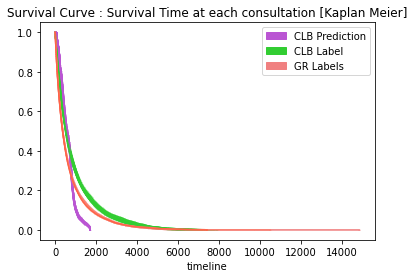

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Create survival time column
    df['survival_time_pred'] = df['pred'].apply(lambda x : label_to_time_survival(x, 800))
    df['survival_time'] = df['lab'].apply(lambda x : label_to_time_survival(x, 800))
    # Fit KM and plot1
    # Prediction
    kmf.fit(df['survival_time_pred'])#, label="CLB"+str(i)+"_pred")
    kmf.plot_survival_function(color="mediumorchid")
    # Prediction
    kmf.fit(df['survival_time'])#, label="CLB"+str(i))
    kmf.plot_survival_function(color="limegreen")

kmf.fit(train_GR['survival_time'])
kmf.plot_survival_function(color="lightcoral")

kmf.fit(validation_GR['survival_time'])
kmf.plot_survival_function(color="salmon")

kmf.fit(test_GR['survival_time'])
kmf.plot_survival_function(color="tomato")

import matplotlib.patches as mpatches
prediction_patch = mpatches.Patch(color='mediumorchid', label='CLB Prediction')
label_patch = mpatches.Patch(color='limegreen', label='CLB Label')
GR_patch = mpatches.Patch(color='lightcoral', label='GR Labels')
plt.legend(handles=[prediction_patch, label_patch, GR_patch])
plt.title("Survival Curve : Survival Time at each consultation [Kaplan Meier]")

Text(0, 0.5, 'Survival Probability')

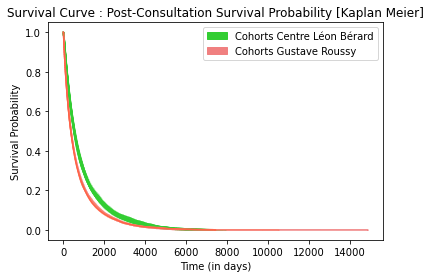

In [14]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

def label_to_time_survival(label, mean_time_survival):
    """
    Transforms labels in ]0,1[ into times of survival
    """
    return - mean_time_survival*np.log(
        np.clip(1-label, a_min=1e-5, a_max=1))

fig, ax = plt.subplots()

for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Create survival time column
    df['survival_time_pred'] = df['pred'].apply(lambda x : label_to_time_survival(x, 800))
    df['survival_time'] = df['lab'].apply(lambda x : label_to_time_survival(x, 800))
    # Fit KM and plot
    # Prediction
    kmf.fit(df['survival_time'])#, label="CLB"+str(i))
    kmf.plot_survival_function(color="limegreen")

kmf.fit(train_GR['survival_time'])
kmf.plot_survival_function(color="lightcoral")

kmf.fit(validation_GR['survival_time'])
kmf.plot_survival_function(color="salmon")

kmf.fit(test_GR['survival_time'])
kmf.plot_survival_function(color="tomato")

import matplotlib.patches as mpatches
prediction_patch = mpatches.Patch(color='mediumorchid', label='CLB Prediction')
label_patch = mpatches.Patch(color='limegreen', label='Cohorts Centre Léon Bérard')
GR_patch = mpatches.Patch(color='lightcoral', label='Cohorts Gustave Roussy')
plt.legend(handles=[label_patch, GR_patch])
plt.title("Survival Curve : Post-Consultation Survival Probability [Kaplan Meier]")
ax.set_xlabel('Time (in days)')        
ax.set_ylabel('Survival Probability')

# Nombre de Compte-Rendu, Survie Moyenne et 1,3th quartile

In [6]:
import pandas as pd 

for i in range(10):
    file_name = "doc_toTest\\test_rs"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = changeFormat(df, False)
    nb_consult = len(df)
    mean_surv = np.mean(df['survival_time'])
    first_q, third_q = df['survival_time'].quantile([0.25,0.75])
    print("Cohort n°"+str(i)+" - MeanSurv: "+str(mean_surv)+" - 1/3 quartiles:"+str(first_q)+"/"+str(third_q)+" - "+str(nb_consult)+"CR")

Cohort n°0 - MeanSurv: 914.1522938028514 - 1/3 quartiles:210.0/1173.0 - 24479CR
Cohort n°1 - MeanSurv: 885.2444092054973 - 1/3 quartiles:209.0/1150.75 - 24594CR
Cohort n°2 - MeanSurv: 903.4813203054438 - 1/3 quartiles:202.0/1136.0 - 24358CR
Cohort n°3 - MeanSurv: 893.9399909139719 - 1/3 quartiles:217.0/1167.0 - 24213CR
Cohort n°4 - MeanSurv: 918.3610132249906 - 1/3 quartiles:217.0/1161.0 - 24121CR
Cohort n°5 - MeanSurv: 882.3547024630954 - 1/3 quartiles:200.0/1162.0 - 23913CR
Cohort n°6 - MeanSurv: 939.048701027483 - 1/3 quartiles:203.0/1207.0 - 23942CR
Cohort n°7 - MeanSurv: 917.5034162118455 - 1/3 quartiles:217.0/1178.0 - 24735CR
Cohort n°8 - MeanSurv: 894.0592056876685 - 1/3 quartiles:207.0/1142.0 - 24474CR
Cohort n°9 - MeanSurv: 886.1489344428659 - 1/3 quartiles:215.0/1127.0 - 24635CR


# Nombre de documents par patients

In [15]:
# Compter le nombre de documents par patients
import pandas as pd 

result = pd.read_csv("doc_toTest\\test_rs0.csv")
result = changeFormat(result, False)

for i in range(1, 10):
    # Read the data
    file_name = "doc_toTest\\test_rs"+str(i)+".csv"
    df_read = pd.read_csv(file_name)
    df_read = changeFormat(df_read, False)
    # Concatenate to have all rows
    frames = [result, df_read]
    result = pd.concat(frames)

result['nb_CR'] = result.groupby(["Noigr"])["Noigr"].transform("count")
result = result.drop_duplicates(subset=['Noigr'])
result['Nb_letter'] = result.Texte.apply(lambda x: len(x)-x.count(" "))
result['Nb_word'] = result.Texte.apply(lambda x: len(x.split()))

# Mean nb letters and nb words
np.mean(result['Nb_letter']), np.mean(result['Nb_word'])

1
2
3
4
5
6
7
8
9


,Noigr,Date cr,Date deces,Texte,survival_time
0,913318,2001-01-15,2001-10-23,Suite des prévisions thérapeutiques Le plan th...,281
1,913318,2001-02-23,2001-10-23,La maladie est évolutive : évolution métastati...,242
2,913318,2001-04-03,2001-10-23,"Poids actuel=74.0kg, Poids il y a 6 mois=72.0k...",203


In [5]:
import pandas as pd 
import numpy as np
import scipy

def label_to_time_survival(label, mean_time_survival):
    """
    Transforms labels in ]0,1[ into times of survival
    """
    return - mean_time_survival*np.log(
        np.clip(1-label, a_min=1e-5, a_max=1))

result = pd.read_csv("doc_Tested\\resu_pred0.csv")
result['survival_time_pred'] = result['pred'].apply(lambda x : label_to_time_survival(x, 800))
result['survival_time'] = result['lab'].apply(lambda x : label_to_time_survival(x, 800))

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Create survival time column
    df['survival_time_pred'] = df['pred'].apply(lambda x : label_to_time_survival(x, 800))
    df['survival_time'] = df['lab'].apply(lambda x : label_to_time_survival(x, 800))

    print(scipy.stats.pearsonr(df['pred'], df['lab']))

    # Concatenate to have all rows
    frames = [result, df]
    result = pd.concat(frames)

(0.6184309112837589, 0.0)
(0.622159781035106, 0.0)
(0.623442927893044, 0.0)
(0.5949392039612762, 0.0)
(0.6348613052489287, 0.0)
(0.6286295422700101, 0.0)
(0.6193708863001178, 0.0)
(0.6096376176700654, 0.0)
(0.6040345416046451, 0.0)


Text(0.5, 1.0, 'Prediction distributions over labels')

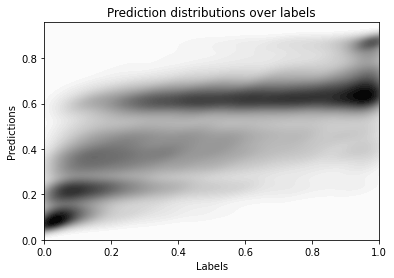

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

n_points = 20
resize_factor = 20
'''gaussian_predictions = np.random.normal(predictions, np.array(stds)/resize_factor, size=(n_points, len(predictions))).flatten().clip(0, 1)
associated_labels = np.tile(test_labels, n_points)'''
sns.kdeplot(
    data={'Predictions': result['pred'], 'Labels': result['lab']}, 
    y='Predictions', x='Labels', clip=((0, 1), (0, 1)),
    fill=True, thresh=0, levels=100, cmap=cm.gray_r
)
plt.title('Prediction distributions over labels')

Text(0.5, 1.0, 'Prediction distributions over labels')

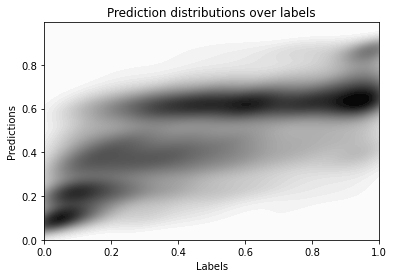

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

n_points = 20
resize_factor = 20
'''gaussian_predictions = np.random.normal(predictions, np.array(stds)/resize_factor, size=(n_points, len(predictions))).flatten().clip(0, 1)
associated_labels = np.tile(test_labels, n_points)'''
sns.kdeplot(
    data={'Predictions': df['pred'], 'Labels': df['lab']}, 
    y='Predictions', x='Labels', clip=((0, 1), (0, 1)),
    fill=True, thresh=0, levels=100, cmap=cm.gray_r
)
plt.title('Prediction distributions over labels')

In [29]:
import matplotlib.pyplot as plt

result = pd.read_csv("doc_Tested\\resu_pred0.csv")
result['survival_time_pred'] = result['pred'].apply(lambda x : label_to_time_survival(x, 800))
result['survival_time'] = result['lab'].apply(lambda x : label_to_time_survival(x, 800))

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Create survival time column
    df['survival_time_pred'] = df['pred'].apply(lambda x : label_to_time_survival(x, 800))
    df['survival_time'] = df['lab'].apply(lambda x : label_to_time_survival(x, 800))
    
    frames = [result, df]
    result = pd.concat(frames)

res = result.drop_duplicates()

Text(0.5, 1.0, 'Survival curve : Survival time at each consultation [Kaplan-Meier]')

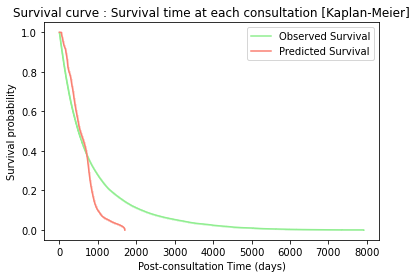

In [35]:
fig, ax = plt.subplots()

kmf.fit(res['survival_time'], label="Observed Survival")
kmf.plot_survival_function(color="lightgreen")

kmf.fit(res['survival_time_pred'], label="Predicted Survival")
kmf.plot_survival_function(color="salmon")

plt.xlabel('Post-consultation Time (days)')
plt.ylabel('Survival probability')

plt.title("Survival curve : Survival time at each consultation [Kaplan-Meier]")

Text(0.5, 1.0, 'Survival curve : Survival time at each consultation [Kaplan-Meier]')

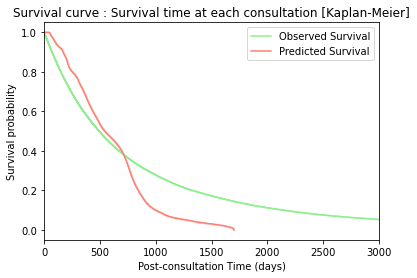

In [36]:
fig, ax = plt.subplots()

kmf.fit(res['survival_time'], label="Observed Survival")
kmf.plot_survival_function(color="lightgreen")

kmf.fit(res['survival_time_pred'], label="Predicted Survival")
kmf.plot_survival_function(color="salmon")

ax.set_xlim([0, 3000])
#ax.set_ylim([ymin, ymax])
plt.xlabel('Post-consultation Time (days)')
plt.ylabel('Survival probability')

plt.title("Survival curve : Survival time at each consultation [Kaplan-Meier]")

## Analyse JUIN pour le papier

In [4]:
import pandas as pd

# Read data
train_GR = pd.read_fwf('doc_GR\\Survival_train.csv', header=None)
train_GR = changeFormat(train_GR, True)
test_GR = pd.read_fwf('doc_GR\\Survival_test.csv', header=None)
test_GR = changeFormat(test_GR, True)

# Split into train/validation
validation_split = pd.read_csv("doc_GR\\validation_split.csv", dtype=bool)
train_GR = train_GR.reset_index().drop(columns=['index']) # Reset index
validation_GR = train_GR[validation_split["validation"]]
train_GR = train_GR.drop(validation_GR.index)

height = [np.mean(train_GR['survival_time']), 
            np.mean(validation_GR['survival_time']),
            np.mean(test_GR['survival_time'])]
bars = ('GR train', 'GR val', 'GR test')

for i in range(10):
    # Read dataframe
    df = pd.read_csv("doc_toTest\\test_rs"+str(i)+".csv")
    df = changeFormat(df, False)

    # Add survival time to list
    height.append(np.mean(df['survival_time']))
    bars += ("CLB_"+str(i), )

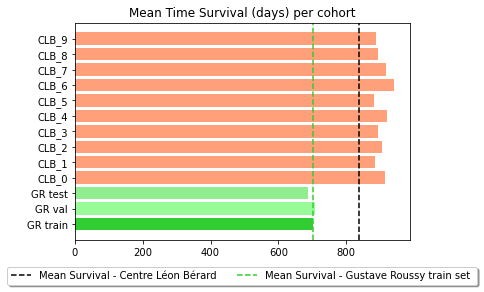

In [5]:
# Plot la figure
fig, ax = plt.subplots()
y_pos = np.arange(len(bars))
plt.barh(y_pos, height, 
    color=['limegreen', 'palegreen', 'lightgreen']+['lightsalmon']*10)
plt.yticks(y_pos, bars)

# Plot vertical line
plt.axvline(x=836.56, linestyle="--", color='black', label="Mean Survival - Centre Léon Bérard")
plt.axvline(x=701.02, linestyle="--", color='limegreen', label="Mean Survival - Gustave Roussy train set ")

plt.title('Mean Time Survival (days) per cohort')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("img_papier_figures\\survival_all_cohorts.png", bbox_inches='tight')

## Refaire les plots bonne qualité

##### CLB - Survival Probability observed per cohort

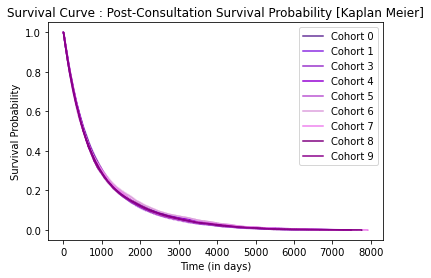

In [53]:
# COHORT CLB
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter

# Function to transform label to survival time
def label_to_time_survival(label, mean_time_survival):
    """
    Transforms labels in ]0,1[ into times of survival
    """
    return - mean_time_survival*np.log(
        np.clip(1-label, a_min=1e-5, a_max=1))

# Color to plot differents CLB cohort
keys_color = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
values_color = ["rebeccapurple", "blueviolet", "indigo", "darkorchid", "darkviolet", 
                "mediumorchid", "plum", "violet", "purple", "darkmagenta"]
colors = {}
for (key, value) in zip(keys_color, values_color):
    colors[key] = value

# Initialize survival Model
kmf = KaplanMeierFitter()

# For each cohort, read data, transform label to survival and plot KM
for i in [0, 1, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Create survival time column
    df['survival_time_pred'] = df['pred'].apply(lambda x : label_to_time_survival(x, 800))
    df['survival_time'] = df['lab'].apply(lambda x : label_to_time_survival(x, 800))
    # Fit KM and plot
    # Prediction
    kmf.fit(df['survival_time'], label="Cohort "+str(i))
    kmf.plot_survival_function(color=colors[i])
plt.title("Survival Curve : Post-Consultation Survival Probability [Kaplan Meier]")
plt.xlabel("Time (in days)")
plt.ylabel("Survival Probability")
plt.savefig("survival_clb_cohorts.png")

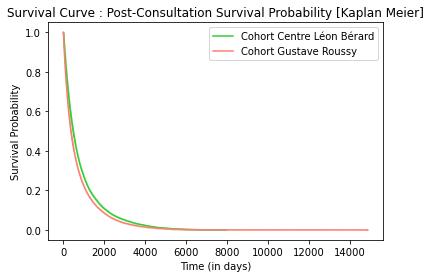

In [43]:
# COHORT CLB + GR
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

def label_to_time_survival(label, mean_time_survival):
    """
    Transforms labels in ]0,1[ into times of survival
    """
    return - mean_time_survival*np.log(
        np.clip(1-label, a_min=1e-5, a_max=1))

fig, ax = plt.subplots()

file_name = "doc_Tested\\resu_pred0.csv"
result = pd.read_csv(file_name)
result = result.iloc[:,1:]

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Concatenate to have all rows
    frames = [result, df]
    result = pd.concat(frames)
result = result.drop_duplicates()

# Create survival time column
result['survival_time_pred'] = result['pred'].apply(lambda x : label_to_time_survival(x, 800))
result['survival_time'] = result['lab'].apply(lambda x : label_to_time_survival(x, 800))
# Fit KM and plot
# Prediction
kmf.fit(result['survival_time'])#, label="CLB"+str(i))
kmf.plot_survival_function(color="limegreen", label='Cohort Centre Léon Bérard')

kmf.fit(train_GR['survival_time'])
kmf.plot_survival_function(color="salmon", label='Cohort Gustave Roussy')
plt.title("Survival Curve : Post-Consultation Survival Probability [Kaplan Meier]")
ax.set_xlabel('Time (in days)')        
ax.set_ylabel('Survival Probability')
plt.savefig("survival_clbGR_cohorts.png")

##### Prediction distributions over labels

In [56]:
import pandas as pd 
import numpy as np
import scipy

def label_to_time_survival(label, mean_time_survival):
    """
    Transforms labels in ]0,1[ into times of survival
    """
    return - mean_time_survival*np.log(
        np.clip(1-label, a_min=1e-5, a_max=1))

result = pd.read_csv("doc_Tested\\resu_pred0.csv")
result['survival_time_pred'] = result['pred'].apply(lambda x : label_to_time_survival(x, 800))
result['survival_time'] = result['lab'].apply(lambda x : label_to_time_survival(x, 800))

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Create survival time column
    df['survival_time_pred'] = df['pred'].apply(lambda x : label_to_time_survival(x, 800))
    df['survival_time'] = df['lab'].apply(lambda x : label_to_time_survival(x, 800))

    print(scipy.stats.pearsonr(df['pred'], df['lab']))

    # Concatenate to have all rows
    frames = [result, df]
    result = pd.concat(frames)

(0.6184309112837589, 0.0)
(0.622159781035106, 0.0)
(0.623442927893044, 0.0)
(0.5949392039612762, 0.0)
(0.6348613052489287, 0.0)
(0.6286295422700101, 0.0)
(0.6193708863001178, 0.0)
(0.6096376176700654, 0.0)
(0.6040345416046451, 0.0)


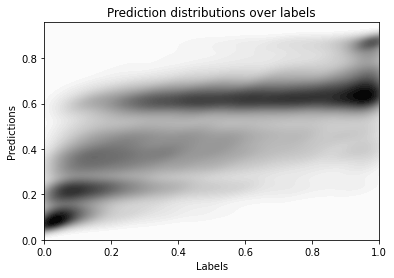

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

n_points = 20
resize_factor = 20
'''gaussian_predictions = np.random.normal(predictions, np.array(stds)/resize_factor, size=(n_points, len(predictions))).flatten().clip(0, 1)
associated_labels = np.tile(test_labels, n_points)'''
sns.kdeplot(
    data={'Predictions': result['pred'], 'Labels': result['lab']}, 
    y='Predictions', x='Labels', clip=((0, 1), (0, 1)),
    fill=True, thresh=0, levels=100, cmap=cm.gray_r
)
plt.title('Prediction distributions over labels')
plt.savefig("img_papier_figures\\prediction_distributions.png", bbox_inches='tight')

### Plot Survie Des Cohortes

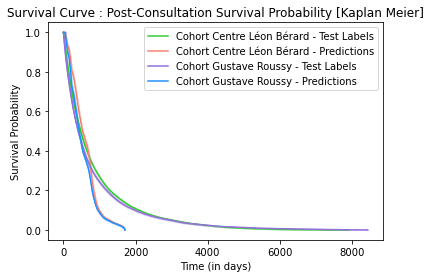

In [1]:
# COHORT CLB + GR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

def label_to_time_survival(label, mean_time_survival):
    """
    Transforms labels in ]0,1[ into times of survival
    """
    return - mean_time_survival*np.log(
        np.clip(1-label, a_min=1e-5, a_max=1))

fig, ax = plt.subplots()

file_name = "doc_Tested\\resu_pred0.csv"
result = pd.read_csv(file_name)
result = result.iloc[:,1:]

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Concatenate to have all rows
    frames = [result, df]
    result = pd.concat(frames)
result = result.drop_duplicates()

# Create survival time column
result['survival_time_pred'] = result['pred'].apply(lambda x : label_to_time_survival(x, 800))
result['survival_time'] = result['lab'].apply(lambda x : label_to_time_survival(x, 800))
# Fit KM and plot
# Prediction
kmf.fit(result['survival_time'])#, label="CLB"+str(i))
kmf.plot_survival_function(color="limegreen", label='Cohort Centre Léon Bérard - Test Labels')

# Prediction
kmf.fit(result['survival_time_pred'])#, label="CLB"+str(i))
kmf.plot_survival_function(color="salmon", label='Cohort Centre Léon Bérard - Predictions')

# Gustave Roussy
tested_GR = pd.read_json("doc_GR\\test.json") # labels, predictions
tested_GR['labels'] = tested_GR['labels'].apply(lambda x: label_to_time_survival(x, 800))
tested_GR['predictions'] = tested_GR['predictions'].apply(lambda x: label_to_time_survival(x, 800))

kmf.fit(tested_GR['labels'])
kmf.plot_survival_function(color="mediumpurple", label='Cohort Gustave Roussy - Test Labels')

kmf.fit(tested_GR['predictions'])
kmf.plot_survival_function(color="dodgerblue", label='Cohort Gustave Roussy - Predictions')

plt.title("Survival Curve : Post-Consultation Survival Probability [Kaplan Meier]")
ax.set_xlabel('Time (in days)')        
ax.set_ylabel('Survival Probability')
plt.savefig("img_papier_figures\\survival_all_cohorts_Unzoom.png", bbox_inches='tight')

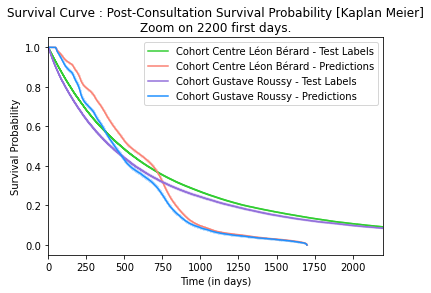

In [2]:
# COHORT CLB + GR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

def label_to_time_survival(label, mean_time_survival):
    """
    Transforms labels in ]0,1[ into times of survival
    """
    return - mean_time_survival*np.log(
        np.clip(1-label, a_min=1e-5, a_max=1))

fig, ax = plt.subplots()

file_name = "doc_Tested\\resu_pred0.csv"
result = pd.read_csv(file_name)
result = result.iloc[:,1:]

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Concatenate to have all rows
    frames = [result, df]
    result = pd.concat(frames)
result = result.drop_duplicates()

# Create survival time column
result['survival_time_pred'] = result['pred'].apply(lambda x : label_to_time_survival(x, 800))
result['survival_time'] = result['lab'].apply(lambda x : label_to_time_survival(x, 800))
# Fit KM and plot
# Prediction
kmf.fit(result['survival_time'])#, label="CLB"+str(i))
kmf.plot_survival_function(color="limegreen", label='Cohort Centre Léon Bérard - Test Labels')

# Prediction
kmf.fit(result['survival_time_pred'])#, label="CLB"+str(i))
kmf.plot_survival_function(color="salmon", label='Cohort Centre Léon Bérard - Predictions')

# Gustave Roussy
tested_GR = pd.read_json("doc_GR\\test.json") # labels, predictions
tested_GR['labels'] = tested_GR['labels'].apply(lambda x: label_to_time_survival(x, 800))
tested_GR['predictions'] = tested_GR['predictions'].apply(lambda x: label_to_time_survival(x, 800))

kmf.fit(tested_GR['labels'])
kmf.plot_survival_function(color="mediumpurple", label='Cohort Gustave Roussy - Test Labels')

kmf.fit(tested_GR['predictions'])
kmf.plot_survival_function(color="dodgerblue", label='Cohort Gustave Roussy - Predictions')

plt.xlim(0, 2200)
plt.title("Survival Curve : Post-Consultation Survival Probability [Kaplan Meier]\nZoom on 2200 first days.")
ax.set_xlabel('Time (in days)')        
ax.set_ylabel('Survival Probability')
plt.savefig("img_papier_figures\\survival_all_cohorts_Zoom.png", bbox_inches='tight')

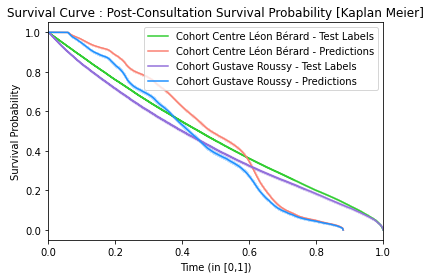

In [8]:
fig, ax = plt.subplots()

file_name = "doc_Tested\\resu_pred0.csv"
result = pd.read_csv(file_name)
result = result.iloc[:,1:]

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    # Concatenate to have all rows
    frames = [result, df]
    result = pd.concat(frames)
result = result.drop_duplicates()

# Create survival time column
result['survival_time_pred'] = result['pred'].apply(lambda x : label_to_time_survival(x, 800))
result['survival_time'] = result['lab'].apply(lambda x : label_to_time_survival(x, 800))
# Fit KM and plot
# Prediction
kmf.fit(result['lab'])#, label="CLB"+str(i))
kmf.plot_survival_function(color="limegreen", label='Cohort Centre Léon Bérard - Test Labels')

# Prediction
kmf.fit(result['pred'])#, label="CLB"+str(i))
kmf.plot_survival_function(color="salmon", label='Cohort Centre Léon Bérard - Predictions')

# Gustave Roussy
tested_GR = pd.read_json("doc_GR\\test.json") # labels, predictions

kmf.fit(tested_GR['labels'])
kmf.plot_survival_function(color="mediumpurple", label='Cohort Gustave Roussy - Test Labels')

kmf.fit(tested_GR['predictions'])
kmf.plot_survival_function(color="dodgerblue", label='Cohort Gustave Roussy - Predictions')
plt.xlim(0, 1)
plt.title("Survival Curve : Post-Consultation Survival Probability [Kaplan Meier]")
ax.set_xlabel('Time (in [0,1])')        
ax.set_ylabel('Survival Probability')
plt.savefig("img_papier_figures\\survival_all_cohorts_01.png", bbox_inches='tight')

#### DataViz sur les EHR

In [62]:
# Compter le nombre de documents par patients
import pandas as pd 

result = pd.read_csv("doc_toTest\\test_rs0.csv")
result = changeFormat(result, False)

for i in range(1, 10):
    # Read the data
    file_name = "doc_toTest\\test_rs"+str(i)+".csv"
    df_read = pd.read_csv(file_name)
    df_read = changeFormat(df_read, False)
    # Concatenate to have all rows
    frames = [result, df_read]
    result = pd.concat(frames)

result = result.drop_duplicates()

##### Mean Words per sentence per EHR

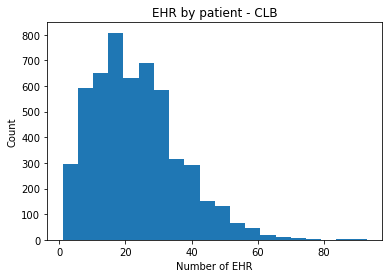

In [66]:
plt.figure(1)
ehr_by_id = result["Noigr"].value_counts()
ehr_by_id.plot.hist(bins=20)
plt.title("EHR by patient - CLB")
plt.xlabel("Number of EHR")
plt.ylabel("Count")
plt.savefig("img_papier_figures\\ehr_distribution.png")

##### Number of Tokens per EHR

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import re 
import json
import numpy as np
from transformers import CamembertTokenizerFast

from kmembert.preprocesser import EHRPreprocesser
from ..utils import print_args, get_label
from .extract_unknown_words import in_camembert_voc

In [ ]:
def count_sentence(x, tokenizer, preprocesser, voc):
    count_token = 0

    x["Texte"] = preprocesser(x["Texte"])

    known_tokens = 0
    for word in re.findall(r'\w+', x["Texte"]):
        word = word.lower()
        if in_camembert_voc(word, voc):
            known_tokens += 1

    nb_tokens = len(tokenizer(x["Texte"], max_length=2000)["input_ids"])
    splitted_by_sentence = re.split(r'[.!?]+', str(x["Texte"]))
    total_sentence = len(splitted_by_sentence) - 1
    for s in splitted_by_sentence :
        if len(s): count_token += (len(tokenizer(s)["input_ids"]) - 1)

    mean_tokens = count_token / max(1, total_sentence)
    return pd.Series([total_sentence, mean_tokens, nb_tokens, known_tokens], index = ["total_sentence", "mean_tokens", "nb_tokens", "known_tokens"])

In [ ]:
df_count = df.apply(lambda x : count_sentence(x, tokenizer, preprocessor, voc), axis=1)

In [ ]:
plt.figure()
max_tokens = df_count["nb_tokens"].max()
nb_tokens_desired = 1500 
plt.xlim((0, min(max_tokens, nb_tokens_desired)))
df_count["nb_tokens"].plot.hist(bins=100)
plt.title("Number of tokens per EHR")
plt.xlabel("Total number of tokens")
plt.savefig(os.path.join(folder_to_save, "nb_tokens_distribution.png"))
plt.close()

#### Survie Moyenne par Cohorte

In [16]:
import pandas as pd

# Read data
train_GR = pd.read_fwf('doc_GR\\Survival_train.csv', header=None)
train_GR = changeFormat(train_GR, True)
test_GR = pd.read_fwf('doc_GR\\Survival_test.csv', header=None)
test_GR = changeFormat(test_GR, True)

# Split into train/validation
validation_split = pd.read_csv("doc_GR\\validation_split.csv", dtype=bool)
train_GR = train_GR.reset_index().drop(columns=['index']) # Reset index
validation_GR = train_GR[validation_split["validation"]]
train_GR = train_GR.drop(validation_GR.index)

height = [np.mean(train_GR['survival_time']), 
            np.mean(validation_GR['survival_time']),
            np.mean(test_GR['survival_time'])]
bars = ('GR train', 'GR val', 'GR test')

quartiles = [tuple(train_GR.survival_time.quantile([0.25,0.75]).tolist()),
                tuple(validation_GR.survival_time.quantile([0.25,0.75]).tolist()),
                tuple(test_GR.survival_time.quantile([0.25,0.75]).tolist())]

for i in range(10):
    # Read dataframe
    df = pd.read_csv("doc_toTest\\test_rs"+str(i)+".csv")
    df = changeFormat(df, False)

    # Add survival time to list
    height.append(np.mean(df['survival_time']))
    bars += ("CLB_"+str(i), )
    # Add quartiles to list
    quartiles += [tuple(df.survival_time.quantile([0.25,0.75]).tolist())]

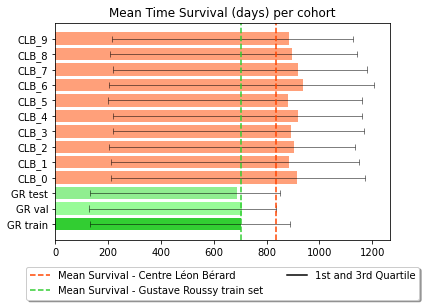

In [32]:
# Plot la figure
fig, ax = plt.subplots()
y_pos = np.arange(len(bars))
plt.barh(y_pos, height, 
    color=['limegreen', 'palegreen', 'lightgreen']+['lightsalmon']*10)
plt.yticks(y_pos, bars)

# Plot vertical line
plt.axvline(x=836.56, linestyle="--", color='orangered', label="Mean Survival - Centre Léon Bérard")
plt.axvline(x=701.02, linestyle="--", color='limegreen', label="Mean Survival - Gustave Roussy train set ")

# Add quartiles to each cohort
i = 0
for quart in quartiles:
    plt.hlines(y=i, xmin=quart[0], xmax=quart[1], linewidth=0.5, colors='black')
    ax.vlines(x=quart[0], ymin=i-0.2, ymax=i+0.2, linewidth=0.5, color='black')
    ax.vlines(x=quart[1], ymin=i-0.2, ymax=i+0.2, linewidth=0.5, color='black')
    i += 1
line_quart_legend, = plt.plot([0], [0], color='black', label="1st and 3rd Quartile")

plt.title('Mean Time Survival (days) per cohort')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)

#plt.savefig("img_papier_figures\\survival_all_cohorts.png", bbox_inches='tight')

### Matrices de confusion

In [13]:
# Concatenate every rows of dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def time_survival_to_label(time_survival, mean_time_survival):
    """
    Transforms times of survival into uniform labels in ]0,1[
    """
    return 1 - np.exp(-time_survival/mean_time_survival)

file_name = "doc_Tested\\resu_pred0.csv"
result = pd.read_csv(file_name)
result = result.iloc[:,1:]

for i in range(1, 10):
    # Read data
    file_name = "doc_Tested\\resu_pred"+str(i)+".csv"
    df = pd.read_csv(file_name)
    df = df.iloc[:,1:]
    
    frames = [result, df]

    result = pd.concat(frames)

result = result.drop_duplicates()

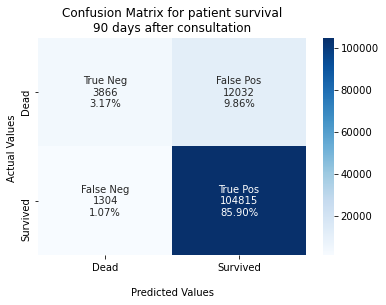

In [37]:
# Confusion matrix for 90 days
import seaborn as sns
# 90, 360, 701
lab_treshold = time_survival_to_label(90, 800)

result['lab_bin'] = result['lab'].apply(lambda x: 1*(x>=lab_treshold))
result['pred_bin'] = result['pred'].apply(lambda x: 1*(x>=lab_treshold))

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(result['lab_bin'], result['pred_bin'])

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for patient survival\n90 days after consultation');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Dead','Survived'])
ax.yaxis.set_ticklabels(['Dead','Survived'])

## Display the visualization of the Confusion Matrix.
plt.savefig("img_papier_figures\\confusionMatrix_90days.png", bbox_inches = 'tight')

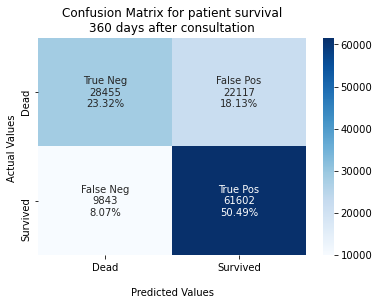

In [38]:
# Confusion matrix for 360 days
import seaborn as sns
# 90, 360, 701
lab_treshold = time_survival_to_label(360, 800)

result['lab_bin'] = result['lab'].apply(lambda x: 1*(x>=lab_treshold))
result['pred_bin'] = result['pred'].apply(lambda x: 1*(x>=lab_treshold))

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(result['lab_bin'], result['pred_bin'])

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for patient survival\n360 days after consultation');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Dead','Survived'])
ax.yaxis.set_ticklabels(['Dead','Survived'])

## Display the visualization of the Confusion Matrix.
plt.savefig("img_papier_figures\\confusionMatrix_360days.png", bbox_inches = 'tight')

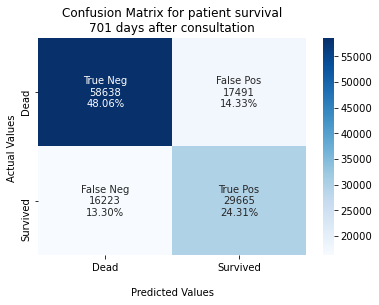

In [39]:
# Confusion matrix for 701 days
import seaborn as sns
lab_treshold = time_survival_to_label(701, 800)

result['lab_bin'] = result['lab'].apply(lambda x: 1*(x>=lab_treshold))
result['pred_bin'] = result['pred'].apply(lambda x: 1*(x>=lab_treshold))

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(result['lab_bin'], result['pred_bin'])

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for patient survival\n701 days after consultation');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Dead','Survived'])
ax.yaxis.set_ticklabels(['Dead','Survived'])

## Display the visualization of the Confusion Matrix.
plt.savefig("img_papier_figures\\confusionMatrix_701days.png", bbox_inches = 'tight')